# AllLife Bank Customer Segmentation Use Case

## Context

AllLife Bank wants to focus on its credit card customer base in the next financial year. They have been advised by their 
marketing research team, that the penetration in the market can be improved. Based on this input, the Marketing team proposes
to run personalized campaigns to target new customers as well as upsell to existing customers. Another insight from the 
market research was that the customers perceive the support services of the back poorly. Based on this, the Operations team 
wants to upgrade the service delivery model, to ensure that customer queries are resolved faster. Head of Marketing and Head 
of Delivery both decide to reach us out for help

## Objective

- To identify different segments in the existing customer, based on their spending patterns as well as past interaction with the bank
- To provide recommendations to the bank on how to better market to and service these customers

## Key Questions

- How many different types (clusters/segments) of the bank customers can be found from the data?
- How do these different groups of customers differ from each other? How do they vary?
- What set of recommandations can we come up with to help the bank

## Data Description

The data provided is of various customers of a bank and their financial attributes like credit limit, the total number of credit cards the customer has, and different channels through which customers have contacted the bank for any queries (including visiting the bank, online and through a call center).


- Sl_No: Primary key of the records
- Customer Key: Customer identification number
- Average Credit Limit: Average credit limit of each customer for all credit cards
- Total credit cards: Total number of credit cards possessed by the customer
- Total visits bank: Total number of visits that customer made (yearly) personally to the bank
- Total visits online: Total number of visits or online logins made by the customer (yearly)
- Total calls made: Total number of calls made by the customer to the bank or its customer service department (yearly)

### Importing necessary libraries

In [148]:
# Libraries to help with reading and manipulating data
import numpy as np
import pandas as pd

# Libraries to help with data visualization
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# Removes the limit for the number of displayed columns
pd.set_option("display.max_columns", None)
# Sets the limit for the number of displayed rows
pd.set_option("display.max_rows", 200)

# to scale the data using z-score
from sklearn.preprocessing import StandardScaler

# to perform k-means clustering and compute silhouette scores
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# to visualize the elbow curve and silhouette scores
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer

# to compute distances
from scipy.spatial.distance import pdist
from scipy.spatial.distance import cdist

# to perform hierarchical clustering, compute cophenetic correlation, and create dendrograms
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage, cophenet

# to perform PCA
from sklearn.decomposition import PCA

# To supress warnings
import warnings

warnings.filterwarnings("ignore")

In [149]:
# loading the dataset
data = pd.read_excel("Credit Card Customer Data.xlsx")

### View the random 10 rows of the dataset.

In [150]:
data.sample(n=10, random_state=1)

,Sl_No,Customer Key,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
547,548,38125,26000,4,5,2,4
353,354,94437,9000,5,4,1,3
499,500,65825,68000,6,4,2,2
173,174,38410,9000,2,1,5,8
241,242,81878,10000,4,5,1,3
341,342,70779,18000,4,3,2,0
647,648,79953,183000,9,0,9,2
218,219,28208,19000,3,1,5,7
120,121,16577,10000,4,2,4,6
134,135,31256,13000,4,1,5,7


In [151]:
# The shape of the data
print(f"The dataset counts {data.shape[0]} rows and {data.shape[1]} columns")

The dataset counts 660 rows and 7 columns


In [152]:
# copying the data to another variable to avoid any changes to original data
df = data.copy()

In [153]:
# dropping the Primary key of the records column as it does not provide any information
df.drop("Sl_No", axis=1, inplace=True)

In [154]:
# Checking the missing values
df.isnull().sum()

Customer Key           0
Avg_Credit_Limit       0
Total_Credit_Cards     0
Total_visits_bank      0
Total_visits_online    0
Total_calls_made       0
dtype: int64

**Observations**

- There is no missing values in the dataset

In [155]:
# let's check for duplicate observations
df.duplicated().sum()

0

**Observations**

- There are no duplicated observations in the dataset

In [156]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 660 entries, 0 to 659
Data columns (total 6 columns):
 #   Column               Non-Null Count  Dtype
---  ------               --------------  -----
 0   Customer Key         660 non-null    int64
 1   Avg_Credit_Limit     660 non-null    int64
 2   Total_Credit_Cards   660 non-null    int64
 3   Total_visits_bank    660 non-null    int64
 4   Total_visits_online  660 non-null    int64
 5   Total_calls_made     660 non-null    int64
dtypes: int64(6)
memory usage: 31.1 KB


**Observations**

- *Customer Key* is normally a categorical variable but here, it'is displayed as numeric.
- The 5 other variables are of type *int* (integer).

In [157]:
# convert *Customer Key* from int to category
df["Customer Key"] = df["Customer Key"].astype('category')

### Summary of the dataset.

In [158]:
# Let's look at the statistical summary of the data
df.describe(include="all").T### Summary of the dataset.

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
Customer Key,660.0,655.0,96929.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Avg_Credit_Limit,660.0,NaN,NaN,NaN,34574.242424,37625.487804,3000.0,10000.0,18000.0,48000.0,200000.0
Total_Credit_Cards,660.0,NaN,NaN,NaN,4.706061,2.167835,1.0,3.0,5.0,6.0,10.0
Total_visits_bank,660.0,NaN,NaN,NaN,2.403030,1.631813,0.0,1.0,2.0,4.0,5.0
Total_visits_online,660.0,NaN,NaN,NaN,2.606061,2.935724,0.0,1.0,2.0,4.0,15.0
Total_calls_made,660.0,NaN,NaN,NaN,3.583333,2.865317,0.0,1.0,3.0,5.0,10.0


**Observations**

- Except for *Customer Key*, all columns are numeric in nature. This column counts 655 unique values. This means that some customers have more than 1 account.
- 50% of the bank customers hold less than 5 credit cards. However, a majority of them have between 4 and 10 credit cards
- All the numeric variables are skewed (left skew for *Total_Credit_Cards* variable and right skew for the others)
- This indicates the probable presence of outliers
- The numerical variables have different ranges and have to be scaled before clustering.

## EDA

### Univariate Analysis

In [159]:
# function to plot a boxplot and a histogram along the same scale.


def histogram_boxplot(data, feature, figsize=(12, 7), kde=False, bins=None):
    """
    Boxplot and histogram combined

    data: dataframe
    feature: dataframe column
    figsize: size of figure (default (12,7))
    kde: whether to the show density curve (default False)
    bins: number of bins for histogram (default None)
    """
    f2, (ax_box2, ax_hist2) = plt.subplots(
        nrows=2,  # Number of rows of the subplot grid= 2
        sharex=True,  # x-axis will be shared among all subplots
        gridspec_kw={"height_ratios": (0.25, 0.75)},
        figsize=figsize,
    )  # creating the 2 subplots
    sns.boxplot(
        data=data, x=feature, ax=ax_box2, showmeans=True, color="violet"
    )  # boxplot will be created and a star will indicate the mean value of the column
    sns.histplot(
        data=data, x=feature, kde=kde, ax=ax_hist2, bins=bins, palette="winter"
    ) if bins else sns.histplot(
        data=data, x=feature, kde=kde, ax=ax_hist2, discrete=True
    )  # For histogram
    ax_hist2.axvline(
        data[feature].mean(), color="green", linestyle="--"
    )  # Add mean to the histogram
    ax_hist2.axvline(
        data[feature].median(), color="black", linestyle="-"
    )  # Add median to the histogram

Wall time: 1min 38s


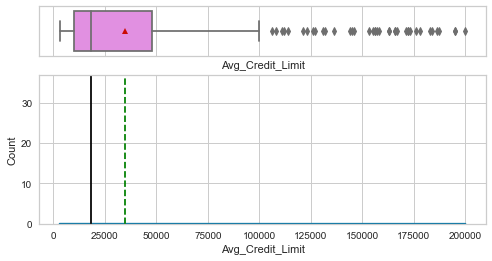

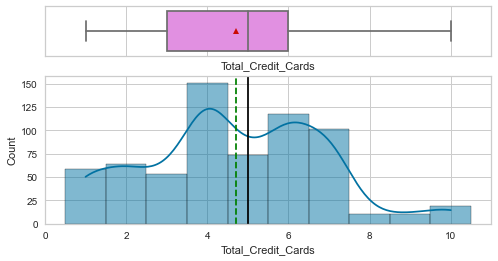

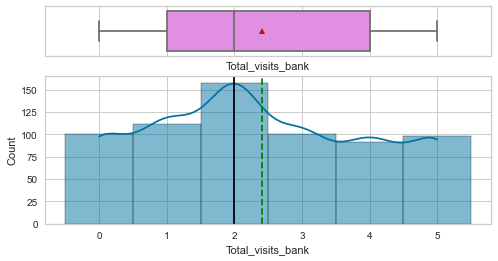

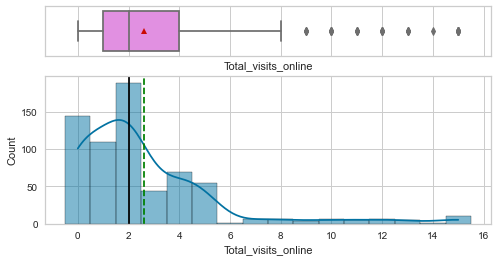

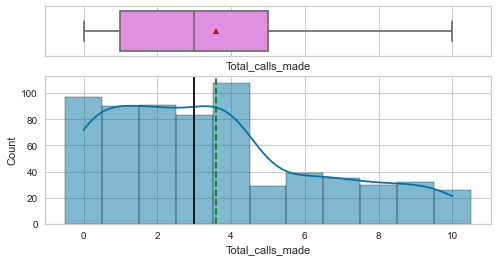

In [160]:
%%time

# selecting numerical columns
num_col = df.select_dtypes(include=np.number).columns.tolist()

for item in num_col:
    histogram_boxplot(df, item, kde=True, figsize=(8, 4))

**Observations:**

- The density curve and the distribution of the variable *Average Credit Limit* is flat. This indicates a low density for each value contained in this variable.
- Approx 25% of the bank customers have an *Avg_Credit_Limit* between 50K and 200K. Presence of extreme upper outliers above 100K. The variable is right skewed
- *Total_visits_online* has some upper outliers and most of the customers have visited the online services less than 3 times


In [161]:
# function to create labeled barplots


def labeled_barplot(data, feature, perc=False, n=None):
    """
    Barplot with percentage at the top

    data: dataframe
    feature: dataframe column
    perc: whether to display percentages instead of count (default is False)
    n: displays the top n category levels (default is None, i.e., display all levels)
    """

    total = len(data[feature])  # length of the column
    count = data[feature].nunique()
    if n is None:
        plt.figure(figsize=(count + 1, 5))
    else:
        plt.figure(figsize=(n + 1, 5))

    plt.xticks(rotation=90, fontsize=15)
    ax = sns.countplot(
        data=data,
        x=feature,
        palette="Paired",
        order=data[feature].value_counts().index[:n].sort_values(),
    )

    for p in ax.patches:
        if perc == True:
            label = "{:.1f}%".format(
                100 * p.get_height() / total
            )  # percentage of each class of the category
        else:
            label = p.get_height()  # count of each level of the category

        x = p.get_x() + p.get_width() / 2  # width of the plot
        y = p.get_height()  # height of the plot

        ax.annotate(
            label,
            (x, y),
            ha="center",
            va="center",
            size=12,
            xytext=(0, 5),
            textcoords="offset points",
        )  # annotate the percentage

    plt.show()  # show the plot

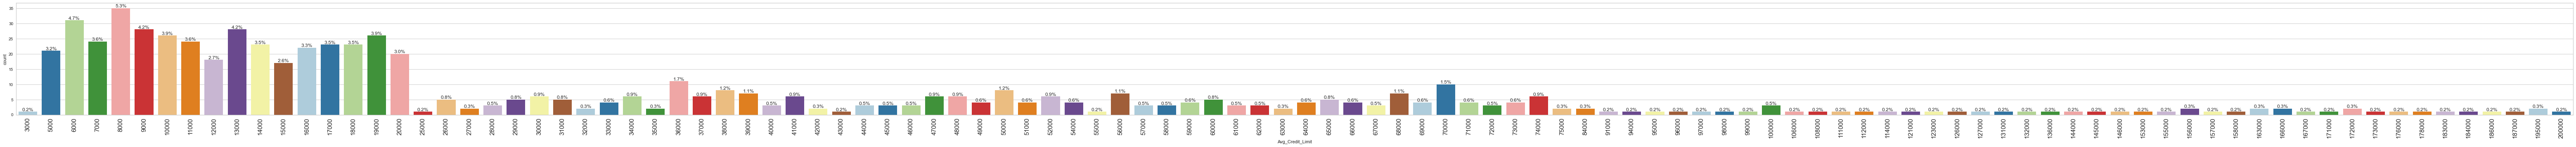

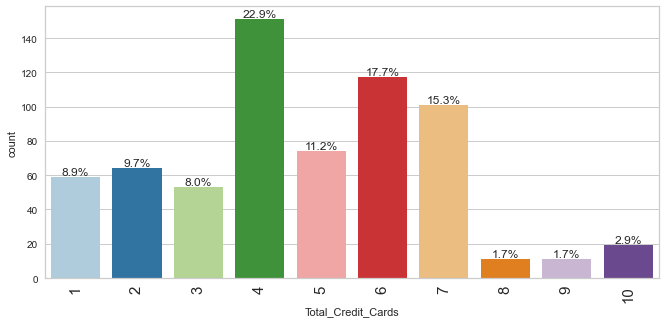

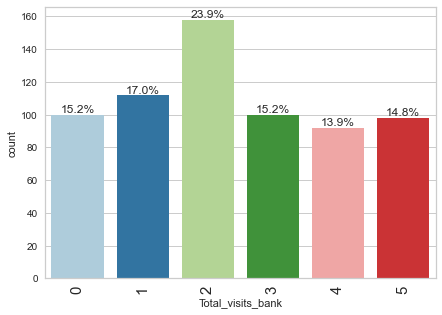

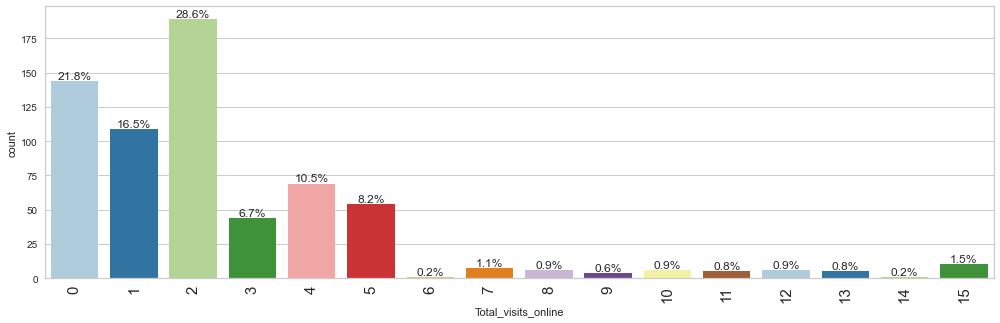

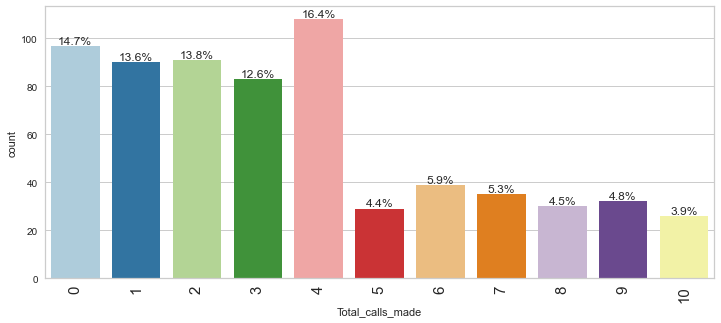

Wall time: 1.63 s


In [162]:
%%time

for item in num_col:
    labeled_barplot(df, item, perc=True)

**Observations:**

- 4, 6 and 7 are the prominent numbers of credit cards held by the bank customers. Only 6.3% of them have more than 7 credit cards.
- 56% of the customers have personally visited the bank less than 3 times during the year and more than 15% of them did no visit during the year
- 22% of the customers did not use the online channel to contact the bank. More than 70% of them used this channel to contact the bank between 1 and 5 times. More than 5 times is rare.
- Approx 15% of the customers did not call the service department of the bank. More than 56% of them call this between 1 and 4 times a year. 
- Each client contacts or visits the bank on average 2 to 4 times a year, considering the different channels of contact. Which seems very little to gain customer loyalty. The bank seems to be  
  resting on its laurels.
- The bank should do something for that

### Bivariate Analysis

**Let's check for correlations.**

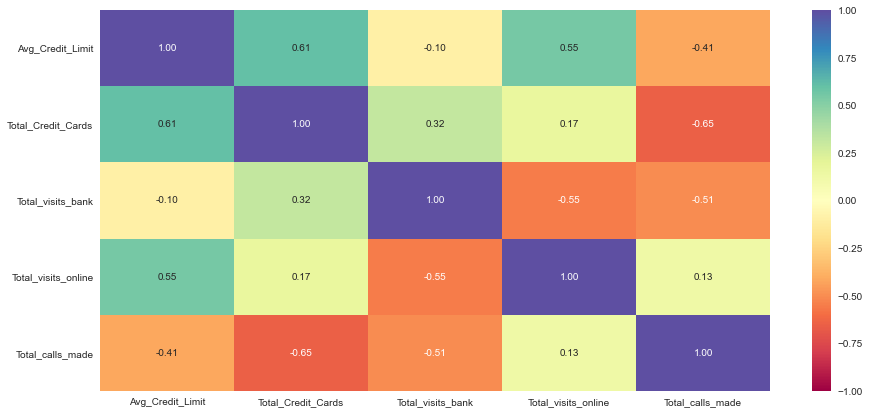

In [163]:
plt.figure(figsize=(15, 7))
sns.heatmap(
    df[num_col].corr(), annot=True, vmin=-1, vmax=1, fmt=".2f", cmap="Spectral"
)
plt.show()

**Observations:**

- *Avg_Credit_Limit* is positively correlated to *Total_Credit_Cards* and *Total_visits_online* 
- *Total calls made* is negatively correlated to *Total_Credit_Cards* and *Total visits bank*
- *Total visits online* and *Total visits bank* are negatively correlated

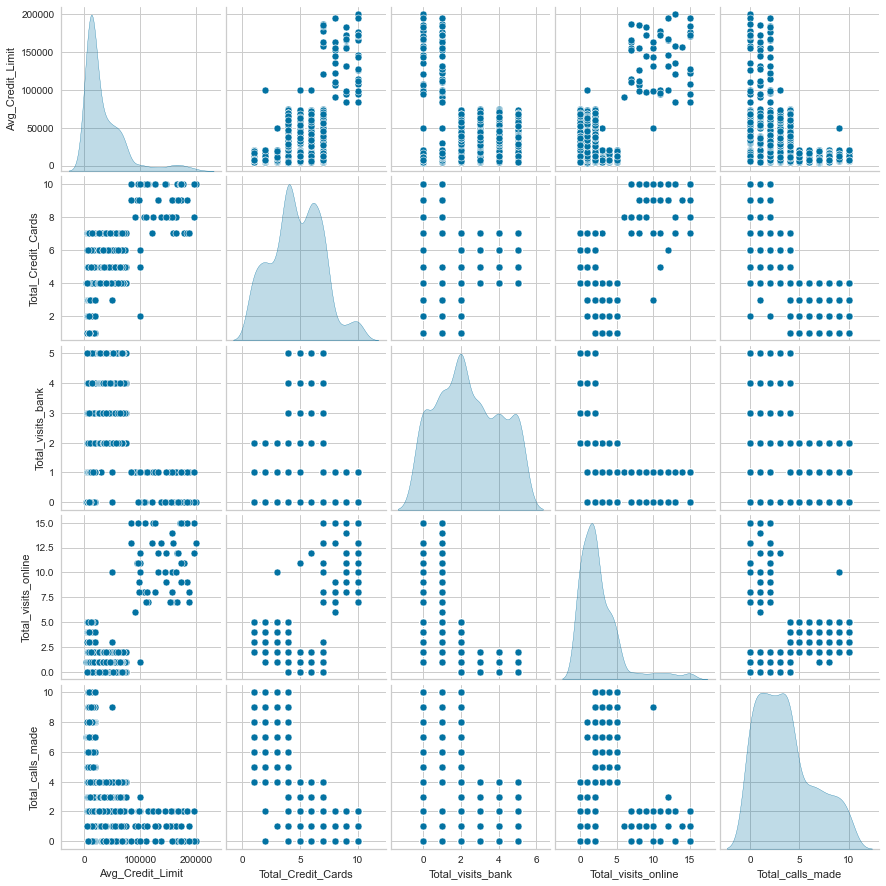

In [164]:
sns.pairplot(data=df[num_col], diag_kind="kde")
plt.show()

**Observations:**

- The variables seem to be multimodal

- **As there is no missing value, no value to be replaced in the columns, no information to extract from the existing columns, we'll not proceed a data preprocessing**
- **Besides, we'll not treat the outliers pointed out during the EDA as the data are consistent with activity**

**As we have customers with more than 1 account, we'll group them**

In [165]:
df = df.groupby('Customer Key').sum().reset_index()

In [166]:
df.shape

(655, 6)

**Observation:**

- The number of customers of the bank is 655 instead of 660

## <a id='link1'>Summary of EDA</a>


- The dataset counts 660 rows and 7 columns
- There is no missing values in the dataset
- There are no duplicated observations in the dataset
- We've droppe the *Primary key* of the records column as it does not provide any information

- *Customer Key* is normally a categorical variable but here, it'is displayed as numeric.
- The 5 other variables are of type *int* (integer).


**Summary of the dataset**

- Except for Customer Key, all columns are numeric in nature. This column counts 655 unique values. This means that some 
  customers have more than 1 account.
- 50% of the bank customers hold less than 5 credit cards. However, a majority of them have between 4 and 10 credit cards
- All the numeric variables are skewed (left skew for Total_Credit_Cards variable and right skew for the others)
- This indicates the probable presence of outliers
- The numerical variables have different ranges and have to be scaled before clustering.


**EDA**:

 - *Univariate Analysis*

   - Numeric variables

    - The density curve and the distribution of the variable *Average Credit Limit* is flat. This indicates a low density for each value contained in this variable.
	- Approx 25% of the bank customers have an *Avg_Credit_Limit* between 50K and 200K. Presence of extreme upper outliers above 100K. The variable is right skewed
	- *Total_visits_online* has some upper outliers and most of the customers have visited the online services less than 3 times


   - Categoric variables

	- 4, 6 and 7 are the prominent numbers of credit cards held by the bank customers. Only 6.3% of them have more than 7 credit cards.
	- 56% of the customers have personally visited the bank less than 3 times during the year and more than 15% of them did no visit during the year
	- 22% of the customers did not use the online channel to contact the bank. More than 70% of them used this channel to contact the bank between 1 and 5 times. More than 5 times is rare.
	- Approx 15% of the customers did not call the service department of the bank. More than 56% of them call this between 1 and 4 times a year. 
	- Each client contacts or visits the bank on average 2 to 4 times a year, considering the different channels of contact. Which seems very little to gain customer loyalty. The bank seems to be  
  	  resting on its laurels.
	- The bank should do something for that


 - *Bivariate Analysis*

    - *Avg_Credit_Limit* is positively correlated to *Total_Credit_Cards* and *Total_visits_online* 
    - *Total calls made* is negatively correlated to *Total_Credit_Cards* and *Total visits bank*
    - *Total visits online* and *Total visits bank* are negatively correlated
    - The numeric varibles seem to be multimodal

- The number of customers of the bank is 655 instead of 660

- **As there is no missing value, no value to be replaced in the columns, no information to extract from the existing columns, we'll not proceed a data preprocessing**
- **Besides, we'll not treat the outliers pointed out during the EDA as the data are consistent with activity**

**As we have customers with more than 1 account, we'll group them**

### Feature scaling

**What is feature scaling?**

Feature scaling is a class of statistical techniques that, as the name implies, scales the features of our data so that they all have a similar range. You'll understand better if we look at an example:

If you have multiple independent variables like age, salary, and height, With their range as (18–100 Years), (25,000–75,000 Euros), and (1–2 Meters) respectively, feature scaling would help them all to be in the same range.

**Why feature scaling is improtant in Unsupervised Learning?**

Feature scaling is specially relevant in machine learning models that compute some sort of distance metric, like most clustering methods like K-Means. 

So, scaling should be done to avoid the problem of one feature dominating over others because the unsupervised learning algorithm uses distance to find the similarity between data points.

## 1. K-means Clustering

In [167]:
# Scaling the data set before clustering
scaler = StandardScaler()
subset = df[num_col].copy()
subset_scaled = scaler.fit_transform(subset)

In [168]:
# Creating a dataframe from the scaled data
subset_scaled_df = pd.DataFrame(subset_scaled, columns=subset.columns)

### **The plot of Elbow curve**

Number of Clusters: 1 	Average Distortion: 1.9987535519850126
Number of Clusters: 2 	Average Distortion: 1.4592168455688803
Number of Clusters: 3 	Average Distortion: 1.1474370162297236
Number of Clusters: 4 	Average Distortion: 1.0494510243907649
Number of Clusters: 5 	Average Distortion: 0.993930042244054
Number of Clusters: 6 	Average Distortion: 0.9468380149111554
Number of Clusters: 7 	Average Distortion: 0.913485002810864
Number of Clusters: 8 	Average Distortion: 0.8935332419075782
Wall time: 355 ms


Text(0.5, 1.0, 'Selecting k with the Elbow Method')

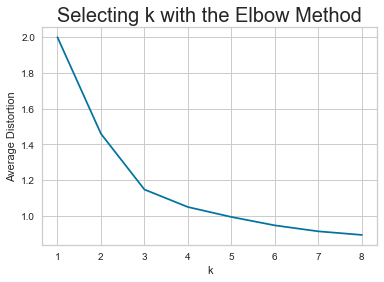

In [169]:
%%time

clusters = range(1, 9)
meanDistortions = []

for k in clusters:
    model = KMeans(n_clusters=k)
    model.fit(subset_scaled_df)
    prediction = model.predict(subset_scaled_df)
    distortion = (
        sum(
            np.min(cdist(subset_scaled_df, model.cluster_centers_, "euclidean"), axis=1)
        )
        / subset_scaled_df.shape[0]
    )

    meanDistortions.append(distortion)

    print("Number of Clusters:", k, "\tAverage Distortion:", distortion)

plt.plot(clusters, meanDistortions, "bx-")
plt.xlabel("k")
plt.ylabel("Average Distortion")
plt.title("Selecting k with the Elbow Method", fontsize=20)

**In the above plot, the elbow is seen for K=2, but if we observe the Average distortion results, there is some drop in distortion at K= 3 and 4.(Even a small elbow at K =4 is observed).** 

### **Let's check the silhouette scores.**

For n_clusters = 2, silhouette score is 0.41274062257093597
For n_clusters = 3, silhouette score is 0.5105444622929342
For n_clusters = 4, silhouette score is 0.3518566809512229
For n_clusters = 5, silhouette score is 0.26864906260811955
For n_clusters = 6, silhouette score is 0.2515104606012953
For n_clusters = 7, silhouette score is 0.24509750419868037
For n_clusters = 8, silhouette score is 0.22454000158362433
For n_clusters = 9, silhouette score is 0.21032108894352508
Wall time: 470 ms


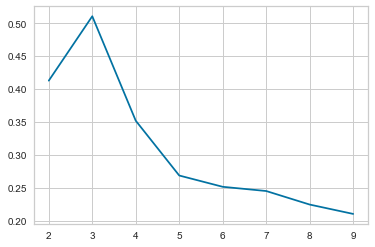

In [170]:
%%time

sil_score = []
cluster_list = list(range(2, 10))
for n_clusters in cluster_list:
    clusterer = KMeans(n_clusters=n_clusters)
    preds = clusterer.fit_predict((subset_scaled_df))
    # centers = clusterer.cluster_centers_
    score = silhouette_score(subset_scaled_df, preds)
    sil_score.append(score)
    print("For n_clusters = {}, silhouette score is {}".format(n_clusters, score))

plt.plot(cluster_list, sil_score)

**From the silhouette scores, it seems that 2 is a good value of k. The silhouette score of k=2 is 0.52**

**How to interpret the results of SilhouetteVisualizer?**

- Below are the points that every cluster needs to satisfy for selecting the optimal K-value.

    - *There should be no negative silhouette coefficient value*
    - *All the clusters should cross the avg silhouette score*
    - *All the clusters should have the different variations (width)*
    - *All the clusters should have different silhouette score*
    
- Note

    - *1) Width of each cluster refers to the size of each cluster. (Number of data points present in each cluster)*
    - *2) Horizontal line refers to the Silhouette score of each cluster.*
    - *3) Dotted red line is an Average Silhouette score.*

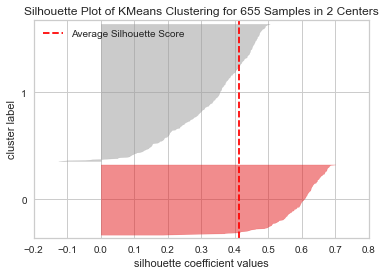

Wall time: 171 ms


<AxesSubplot:title={'center':'Silhouette Plot of KMeans Clustering for 655 Samples in 2 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [171]:
%%time

# finding optimal no. of clusters with silhouette coefficients
visualizer = SilhouetteVisualizer(KMeans(2, random_state=1))
visualizer.fit(subset_scaled_df)
visualizer.show()

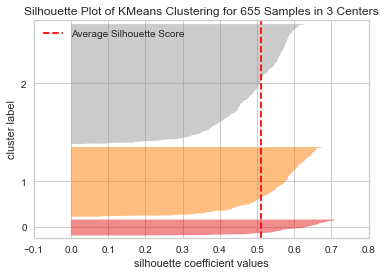

Wall time: 172 ms


<AxesSubplot:title={'center':'Silhouette Plot of KMeans Clustering for 655 Samples in 3 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [172]:
%%time

# finding optimal no. of clusters with silhouette coefficients
visualizer = SilhouetteVisualizer(KMeans(3, random_state=1))
visualizer.fit(subset_scaled_df)
visualizer.show()

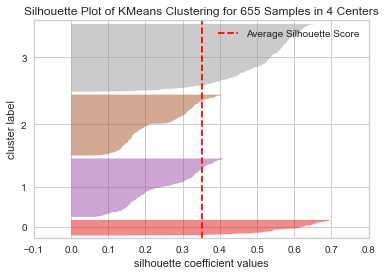

Wall time: 181 ms


<AxesSubplot:title={'center':'Silhouette Plot of KMeans Clustering for 655 Samples in 4 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [173]:
%%time

# finding optimal no. of clusters with silhouette coefficients
visualizer = SilhouetteVisualizer(KMeans(4, random_state=1))
visualizer.fit(subset_scaled_df)
visualizer.show()

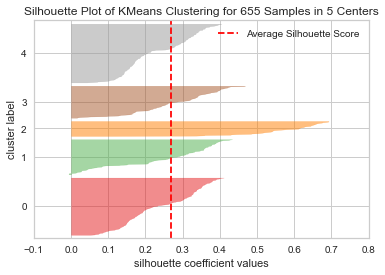

Wall time: 196 ms


<AxesSubplot:title={'center':'Silhouette Plot of KMeans Clustering for 655 Samples in 5 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [174]:
%%time

# finding optimal no. of clusters with silhouette coefficients
visualizer = SilhouetteVisualizer(KMeans(5, random_state=1))
visualizer.fit(subset_scaled_df)
visualizer.show()

**Let's take 3 as the appropriate no. of clusters(K) as the silhouette score is high enough for all the 3-clusters(above average silhouette score).**

In [175]:
kmeans = KMeans(n_clusters=3, random_state=0)
kmeans.fit(subset_scaled_df)

KMeans(n_clusters=3, random_state=0)

In [176]:
# adding kmeans cluster labels to the original dataframe
df["K_means_segments"] = kmeans.labels_
subset_scaled_df["K_means_segments"] = kmeans.labels_

### **Cluster Profiling**

In [177]:
cluster_profile = df.groupby("K_means_segments").mean()

In [178]:
cluster_profile["count_in_each_segment"] = (
    df.groupby("K_means_segments")["Avg_Credit_Limit"].count().values
)

In [179]:
# let's display cluster profiles
cluster_profile.style.highlight_max(color="lightgreen", axis=0)

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made,count_in_each_segment
K_means_segments,,,,,,
0,12180.180180,2.405405,0.936937,3.567568,6.851351,222
1,34018.276762,5.550914,3.509138,0.992167,2.036554,383
2,141720.000000,8.920000,0.680000,10.960000,1.280000,50


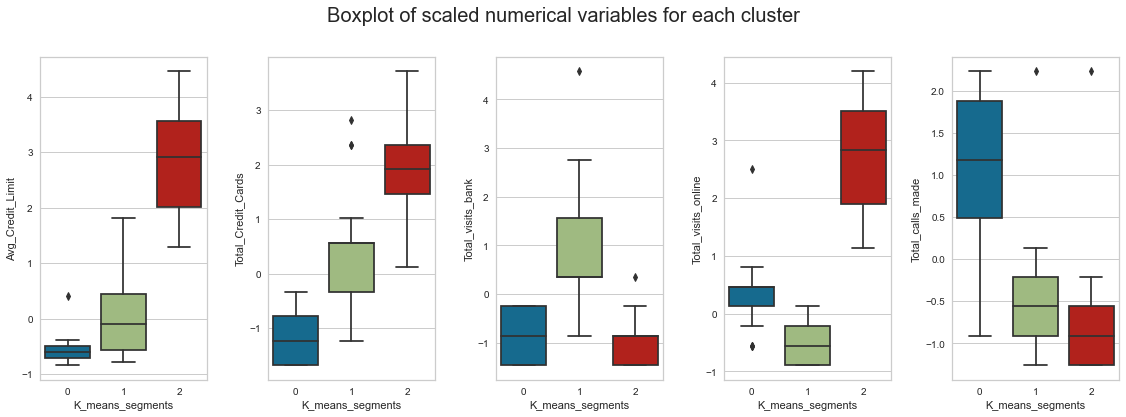

In [180]:
fig, axes = plt.subplots(1, 5, figsize=(16, 6))
fig.suptitle("Boxplot of scaled numerical variables for each cluster", fontsize=20)
counter = 0
for ii in range(5):
    sns.boxplot(
        ax=axes[ii],
        y=subset_scaled_df[num_col[counter]],
        x=subset_scaled_df["K_means_segments"],
    )
    counter = counter + 1

fig.tight_layout(pad=2.0)

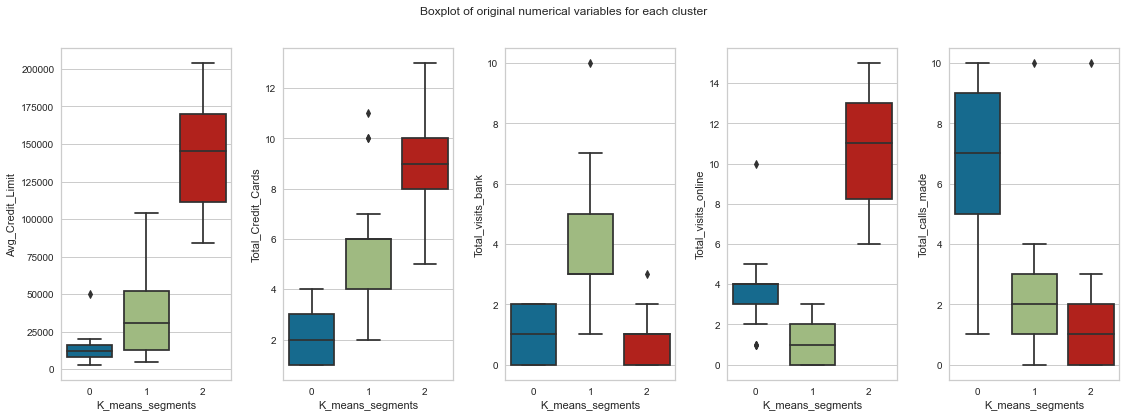

In [181]:
fig, axes = plt.subplots(1, 5, figsize=(16, 6))
fig.suptitle("Boxplot of original numerical variables for each cluster")
counter = 0
for ii in range(5):
    sns.boxplot(ax=axes[ii], y=df[num_col[counter]], x=df["K_means_segments"])
    counter = counter + 1

fig.tight_layout(pad=2.0)

**Let's compare Cluster vs Customer Key**

In [182]:
pd.crosstab(df.K_means_segments, df['Customer Key']).style.highlight_max(
    color="lightgreen", axis=0
)

## K-Means Insights (takeaways)

- **Cluster 0**:

    - There are 222 customers in this cluster.
    - Average Credit Limit is very low.
    - The total number of credit cards possessed by the customers is low. Very few are moderate
    - The total number of visits that customer made (yearly) personally to the bank is low
    - The Total number of visits or online logins made by the customer (yearly) is moderate
    - The total number of calls made by the customer to the bank's customer service department (yearly) is high


- **Cluster 1**:

    - There are 383 customers in this cluster.
    - Average Credit Limit is low to moderate.
    - The Total number of credit cards possessed by the customers is moderate 
    - The Total number of visits that customer made (yearly) personally to the bank is moderate to high
    - The Total number of visits or online logins made by the customer (yearly) is very low
    - The total number of calls made by the customer to the bank's customer service department (yearly) is low to moderate



- **Cluster 2**:

    - There are 50 customers in this cluster.
    - Average Credit Limit is high.
    - The total number of credit cards possessed by the customers is high
    - The total number of visits that customer made (yearly) personally to the bank is low 
    - The Total number of visits or online logins made by the customer (yearly) is high
    - The total number of calls made by the customer to the bank's customer service department (yearly) is low

## 2. Hierarchical Clustering

**As we already have scaled our data, let's find the Cophenetic correlation for different distances with different linkage methods.**

### **Hierarchical clustering with different linkage methods**

### What is Cophenetic correlation? 

The cophenetic correlation coefficient is a correlation coefficient between the cophenetic distances(Dendrogramic distance) obtained from the tree, and the original distances used to construct the tree. It is a measure of how faithfully a dendrogram preserves the pairwise distances between the original unmodeled data points. 

The cophenetic distance between two observations is represented in a dendrogram by the height of the link at which those two observations are first joined. That height is the distance between the two subclusters that are merged by that link.

Cophenetic correlation is the way to compare two or more dendrograms. 

In [183]:
# The scaled dataset
subset_scaled_df = subset_scaled_df.iloc[:,:-1]

In [184]:
%%time

# list of distance metrics
distance_metrics = ["euclidean", "chebyshev", "mahalanobis", "cityblock"]

# list of linkage methods
linkage_methods = ["single", "complete", "average", "weighted"]

high_cophenet_corr = 0
high_dm_lm = [0, 0]

for dm in distance_metrics:
    for lm in linkage_methods:
        Z = linkage(subset_scaled_df, metric=dm, method=lm)
        c, coph_dists = cophenet(Z, pdist(subset_scaled_df))
        print(
            "Cophenetic correlation for {} distance and {} linkage is {}.".format(
                dm.capitalize(), lm, c
            )
        )
        if high_cophenet_corr < c:
            high_cophenet_corr = c
            high_dm_lm[0] = dm
            high_dm_lm[1] = lm

Cophenetic correlation for Euclidean distance and single linkage is 0.7296666486419278.
Cophenetic correlation for Euclidean distance and complete linkage is 0.8754561919596837.
Cophenetic correlation for Euclidean distance and average linkage is 0.8979771743691038.
Cophenetic correlation for Euclidean distance and weighted linkage is 0.8872556537496481.
Cophenetic correlation for Chebyshev distance and single linkage is 0.6846338354043388.
Cophenetic correlation for Chebyshev distance and complete linkage is 0.857474096645806.
Cophenetic correlation for Chebyshev distance and average linkage is 0.8965466808482003.
Cophenetic correlation for Chebyshev distance and weighted linkage is 0.8616538647062754.
Cophenetic correlation for Mahalanobis distance and single linkage is 0.6330165211506836.
Cophenetic correlation for Mahalanobis distance and complete linkage is 0.6876954721509788.
Cophenetic correlation for Mahalanobis distance and average linkage is 0.8102248262385583.
Cophenetic cor

In [185]:
# printing the combination of distance metric and linkage method with the highest cophenetic correlation
print(
    "Highest cophenetic correlation is {}, which is obtained with {} distance and {} linkage.".format(
        high_cophenet_corr, high_dm_lm[0].capitalize(), high_dm_lm[1]
    )
)

Highest cophenetic correlation is 0.8979771743691038, which is obtained with Euclidean distance and average linkage.


**Let's explore different linkage methods with Euclidean distance only.**

In [186]:
%%time

# list of linkage methods
linkage_methods = ["single", "complete", "average", "centroid", "ward", "weighted"]

high_cophenet_corr = 0
high_dm_lm = [0, 0]

for lm in linkage_methods:
    Z = linkage(subset_scaled_df, metric="euclidean", method=lm)
    c, coph_dists = cophenet(Z, pdist(subset_scaled_df))
    print("Cophenetic correlation for {} linkage is {}.".format(lm, c))
    if high_cophenet_corr < c:
        high_cophenet_corr = c
        high_dm_lm[0] = "euclidean"
        high_dm_lm[1] = lm

Cophenetic correlation for single linkage is 0.7296666486419278.
Cophenetic correlation for complete linkage is 0.8754561919596837.
Cophenetic correlation for average linkage is 0.8979771743691038.
Cophenetic correlation for centroid linkage is 0.8943386470059156.
Cophenetic correlation for ward linkage is 0.7283713869631802.
Cophenetic correlation for weighted linkage is 0.8872556537496481.
Wall time: 83.8 ms


In [187]:
# printing the combination of distance metric and linkage method with the highest cophenetic correlation
print(
    "Highest cophenetic correlation is {}, which is obtained with {} linkage.".format(
        high_cophenet_corr, high_dm_lm[1]
    )
)

Highest cophenetic correlation is 0.8979771743691038, which is obtained with average linkage.


**We see that the cophenetic correlation is maximum with Euclidean distance and average linkage.**

### **Let's see the dendrograms for the different linkage methods.**

Wall time: 3.05 s


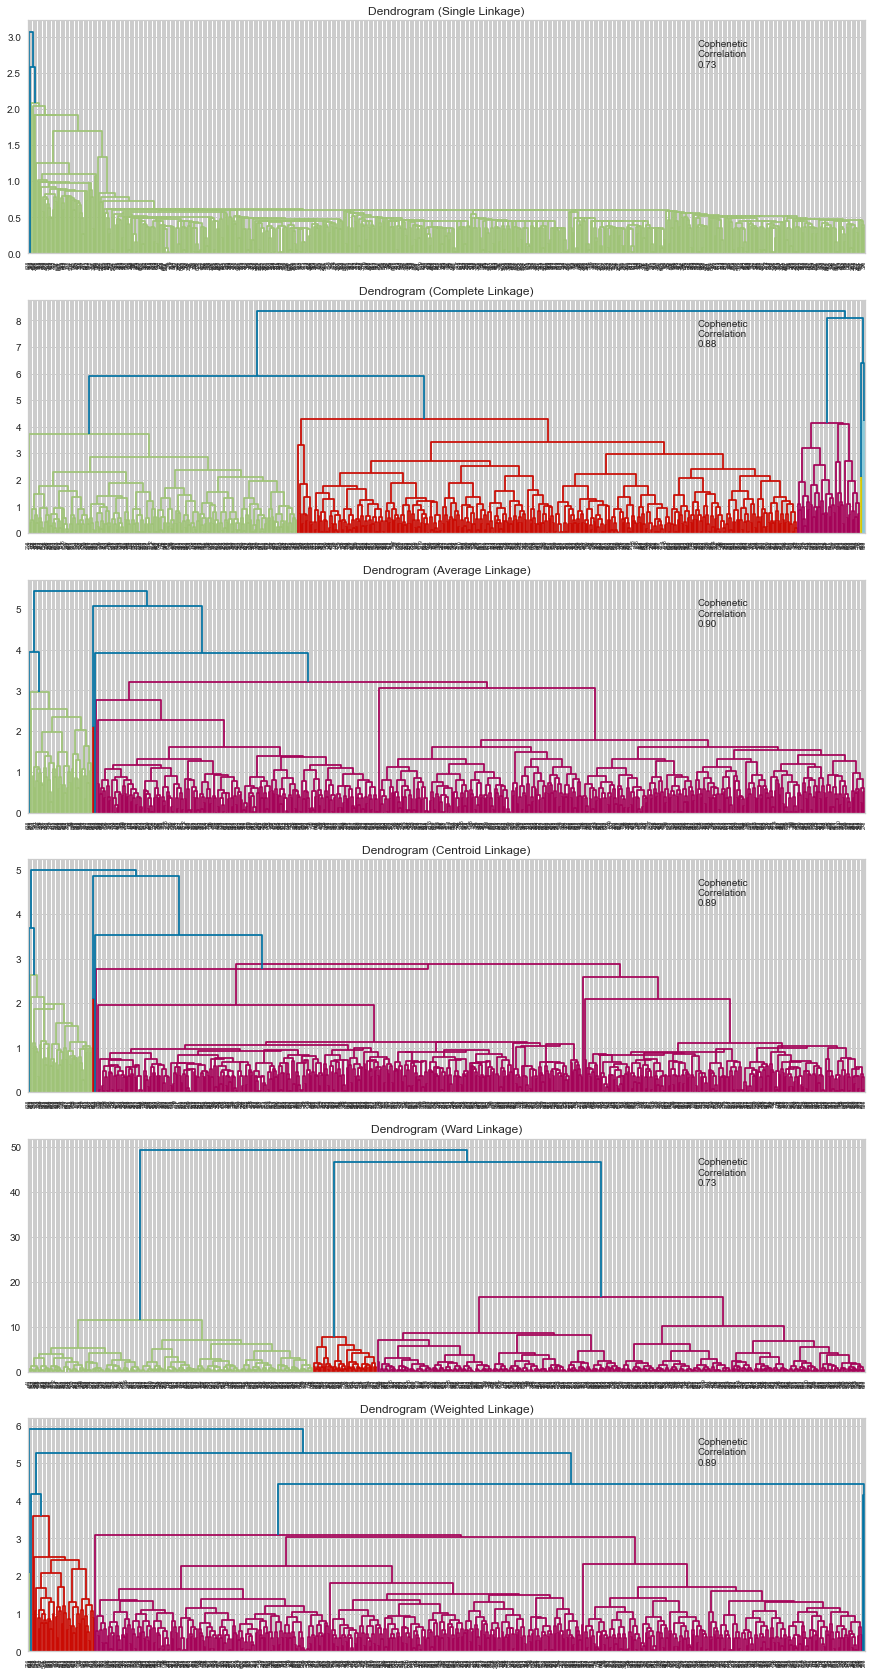

In [188]:
%%time

# list of linkage methods
linkage_methods = ["single", "complete", "average", "centroid", "ward", "weighted"]

# lists to save results of cophenetic correlation calculation
compare_cols = ["Linkage", "Cophenetic Coefficient"]

# to create a subplot image
fig, axs = plt.subplots(len(linkage_methods), 1, figsize=(15, 30))

# We will enumerate through the list of linkage methods above
# For each linkage method, we will plot the dendrogram and calculate the cophenetic correlation
for i, method in enumerate(linkage_methods):
    Z = linkage(subset_scaled_df, metric="euclidean", method=method)

    dendrogram(Z, ax=axs[i])
    axs[i].set_title(f"Dendrogram ({method.capitalize()} Linkage)")

    coph_corr, coph_dist = cophenet(Z, pdist(subset_scaled_df))
    axs[i].annotate(
        f"Cophenetic\nCorrelation\n{coph_corr:0.2f}",
        (0.80, 0.80),
        xycoords="axes fraction",
    )

**Observations:**

- The cophenetic correlation is highest for 3 likage methods. In order, we have average (0.90), centroid and weighted (0.89 both) linkage methods.
- We will move ahead with Average Linkage.
- 5 appears to be the appropriate number of clusters from the dendrogram for Average Linkage.

**The optimal number of clusters from a dendrogram can be obtained by deciding where to cut the cluster tree. Generally, the cluster tree is cut where dendrogram height is maximum as it generally corresponds to distinct and homogeneous clusters.
The dendrogram for average linkage had the highest cophenetic correlation. So we can use average linkage and have chosen 5 clusters as the dendrogram height is pretty high. (The maximum height is for 3, but that would not be meaningful as it would give one cluster with more than 9/10 of customers).**

**Lets visualize the dendrogram cut for average link in the below plot**

Wall time: 572 ms


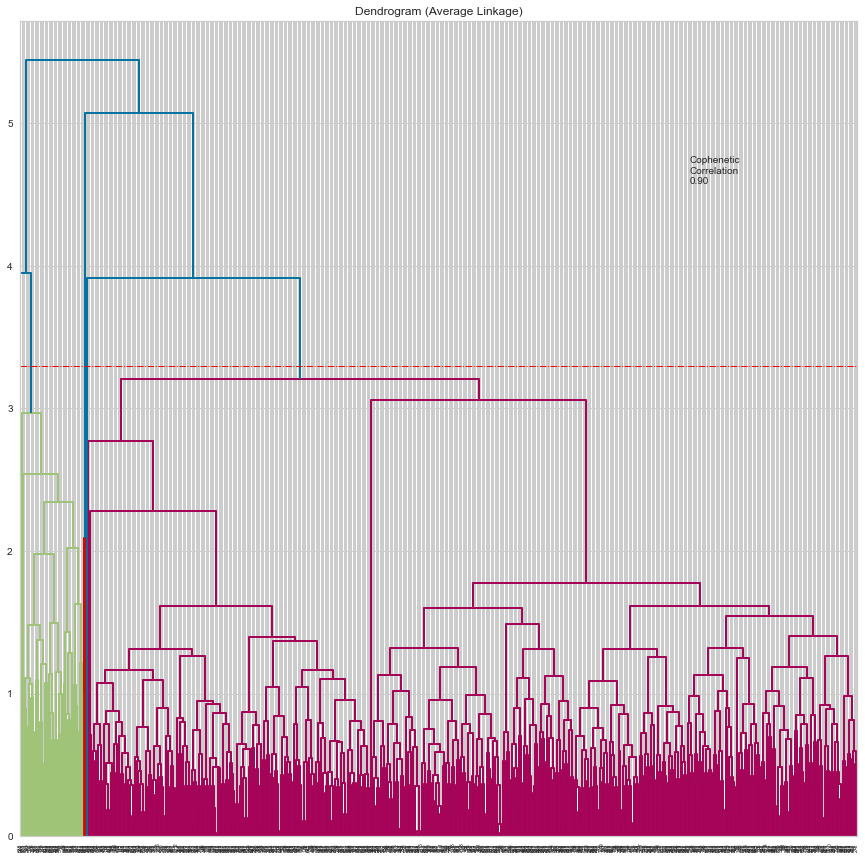

In [189]:
%%time

# list of linkage methods
linkage_methods = ["average"]

# lists to save results of cophenetic correlation calculation
compare_cols = ["Linkage", "Cophenetic Coefficient"]

# to create a subplot image
fig, axs = plt.subplots(len(linkage_methods), 1, figsize=(15, 15))

# We will enumerate through the list of linkage methods above
# For each linkage method, we will plot the dendrogram and calculate the cophenetic correlation
for i, method in enumerate(linkage_methods):
    Z = linkage(subset_scaled_df, metric="euclidean", method=method)

    dendrogram(Z, ax=axs)
    axs.set_title(f"Dendrogram ({method.capitalize()} Linkage)")

    coph_corr, coph_dist = cophenet(Z, pdist(subset_scaled_df))
    axs.annotate(
        f"Cophenetic\nCorrelation\n{coph_corr:0.2f}",
        (0.80, 0.80),
        xycoords="axes fraction",
    )
dendrogram(Z, color_threshold=3.3)
plt.axhline(y=3.3, c="red", lw=1, linestyle="dashdot")

**Hierarchical Clustering**

In [190]:
HCmodel = AgglomerativeClustering(n_clusters=5, affinity="euclidean", linkage="average")
HCmodel.fit(subset_scaled_df)

AgglomerativeClustering(linkage='average', n_clusters=5)

In [191]:
subset_scaled_df["HC_Clusters"] = HCmodel.labels_
df["HC_Clusters"] = HCmodel.labels_

## **Cluster Profiling**

In [192]:
cluster_profile = df.groupby("HC_Clusters").mean()

In [193]:
cluster_profile["count_in_each_segments"] = (
    df.groupby("HC_Clusters")["Avg_Credit_Limit"].count().values
)

In [194]:
# let's see the Customer identification number in each cluster
for cl in df["HC_Clusters"].unique():
    print("In cluster {}, the following customers are present:".format(cl))
    print(df[df["HC_Clusters"] == cl]["Customer Key"].unique())
    print()

In cluster 0, the following customers are present:
[11265, 11398, 11412, 11466, 11562, ..., 99284, 99437, 99473, 99589, 99596]
Length: 602
Categories (602, int64): [11265, 11398, 11412, 11466, ..., 99437, 99473, 99589, 99596]

In cluster 1, the following customers are present:
[13315, 14916, 15585, 16180, 17538, ..., 91575, 94391, 97285, 98216, 99843]
Length: 49
Categories (49, int64): [13315, 14916, 15585, 16180, ..., 94391, 97285, 98216, 99843]

In cluster 4, the following customers are present:
[37252]
Categories (1, int64): [37252]

In cluster 2, the following customers are present:
[50706, 96929]
Categories (2, int64): [50706, 96929]

In cluster 3, the following customers are present:
[97935]
Categories (1, int64): [97935]



**We see that there are 2 clusters with 1 customer, 1 cluster with 2 customers. The rest 2 clusters have respectively 602 and 49 customers.**




**On checking the cluster profiles, it's found average linkage still does not give proper clustering. On checking the dendrogram for different linkages further, the Ward linkage gives us homogeneous clusters, with more variability between clusters, despite a low cophenetic correlation than Average linkage. Let us try using Ward linkage as it has more distinct and separated clusters (as seen from its dendrogram before). 3 appears to be the appropriate number of clusters from the dendrogram for Ward linkage.**

**Lets visualize the dendrogram cut for ward linkage in the below plot**

Wall time: 584 ms


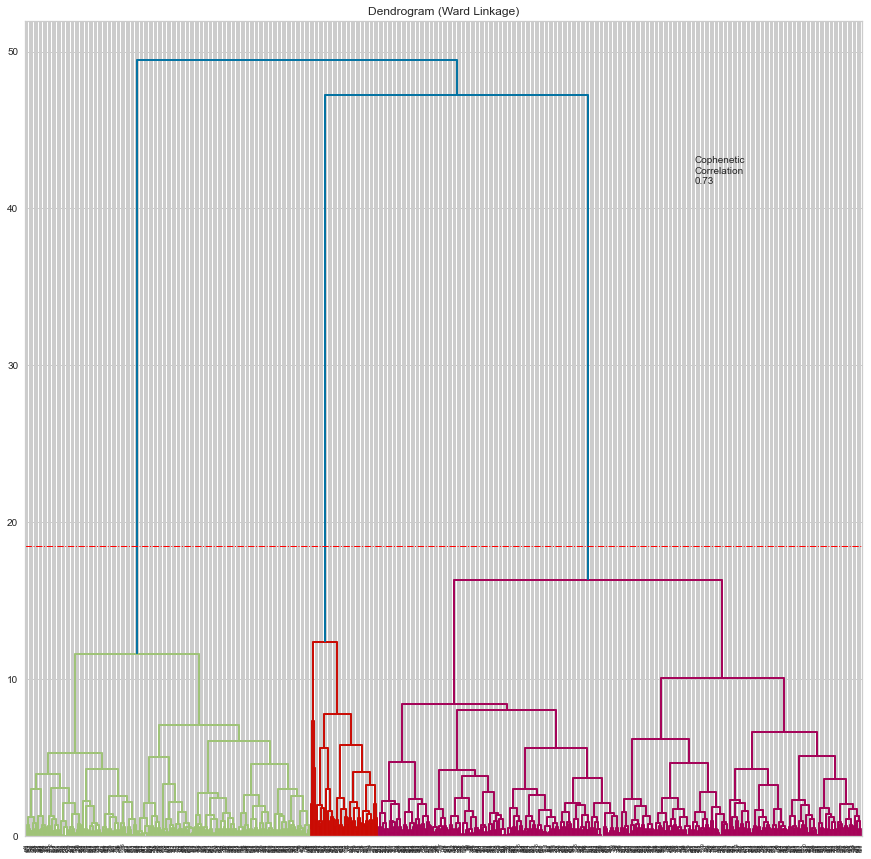

In [195]:
%%time

# list of linkage methods
linkage_methods = ["ward"]

# lists to save results of cophenetic correlation calculation
compare_cols = ["Linkage", "Cophenetic Coefficient"]

# to create a subplot image
fig, axs = plt.subplots(len(linkage_methods), 1, figsize=(15, 15))

# We will enumerate through the list of linkage methods above
# For each linkage method, we will plot the dendrogram and calculate the cophenetic correlation
for i, method in enumerate(linkage_methods):
    Z = linkage(subset_scaled_df, metric="euclidean", method=method)

    dendrogram(Z, ax=axs)
    axs.set_title(f"Dendrogram ({method.capitalize()} Linkage)")

    coph_corr, coph_dist = cophenet(Z, pdist(subset_scaled_df))
    axs.annotate(
        f"Cophenetic\nCorrelation\n{coph_corr:0.2f}",
        (0.80, 0.80),
        xycoords="axes fraction",
    )
dendrogram(Z, color_threshold=18.5)
plt.axhline(y=18.5, c="red", lw=1, linestyle="dashdot")

In [196]:
HCmodel = AgglomerativeClustering(n_clusters=3, affinity="euclidean", linkage="ward")
HCmodel.fit(subset_scaled_df)

AgglomerativeClustering(n_clusters=3)

In [197]:
subset_scaled_df["HC_Clusters"] = HCmodel.labels_
df["HC_Clusters"] = HCmodel.labels_

**Cluster profiling 2**

In [198]:
cluster_profile = df.groupby("HC_Clusters").mean()

In [199]:
cluster_profile["count_in_each_segments"] = (
    df.groupby("HC_Clusters")["Avg_Credit_Limit"].count().values
)

In [200]:
# # let's see the Customer identification number in each cluster
for cl in df["HC_Clusters"].unique():
    print(
        "The",
        df[df["HC_Clusters"] == cl]["Customer Key"].nunique(),
        "customers in cluster",
        cl,
        "are:",
    )
    print(df[df["HC_Clusters"] == cl]["Customer Key"].unique())
    print("-" * 100, "\n")

The 379 customers in cluster 0 are:
[11265, 11398, 11466, 11562, 11596, ..., 98126, 99131, 99284, 99437, 99473]
Length: 379
Categories (379, int64): [11265, 11398, 11466, 11562, ..., 99131, 99284, 99437, 99473]
---------------------------------------------------------------------------------------------------- 

The 223 customers in cluster 1 are:
[11412, 11602, 11937, 12026, 12122, ..., 98602, 98969, 99026, 99589, 99596]
Length: 223
Categories (223, int64): [11412, 11602, 11937, 12026, ..., 98969, 99026, 99589, 99596]
---------------------------------------------------------------------------------------------------- 

The 53 customers in cluster 2 are:
[13315, 14916, 15585, 16180, 17538, ..., 96929, 97285, 97935, 98216, 99843]
Length: 53
Categories (53, int64): [13315, 14916, 15585, 16180, ..., 97285, 97935, 98216, 99843]
---------------------------------------------------------------------------------------------------- 



**Now the clusters seem to have more variability.**

In [201]:
# lets display cluster profile
cluster_profile.style.highlight_max(color="lightgreen", axis=0)

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made,K_means_segments,count_in_each_segments
HC_Clusters,,,,,,,
0,33701.846966,5.514512,3.490765,0.978892,2.005277,1.000000,379
1,12156.950673,2.417040,0.941704,3.560538,6.838565,0.004484,223
2,138396.226415,9.000000,1.000000,10.471698,1.509434,1.943396,53


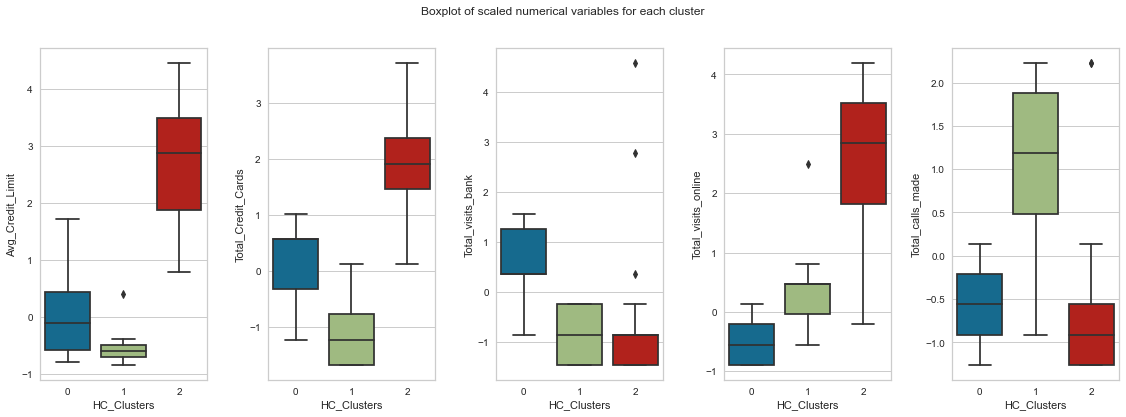

In [202]:
fig, axes = plt.subplots(1, 5, figsize=(16, 6))
fig.suptitle("Boxplot of scaled numerical variables for each cluster")
counter = 0
for ii in range(5):
    sns.boxplot(
        ax=axes[ii],
        y=subset_scaled_df[num_col[counter]],
        x=subset_scaled_df["HC_Clusters"],
    )
    counter = counter + 1

fig.tight_layout(pad=2.0)

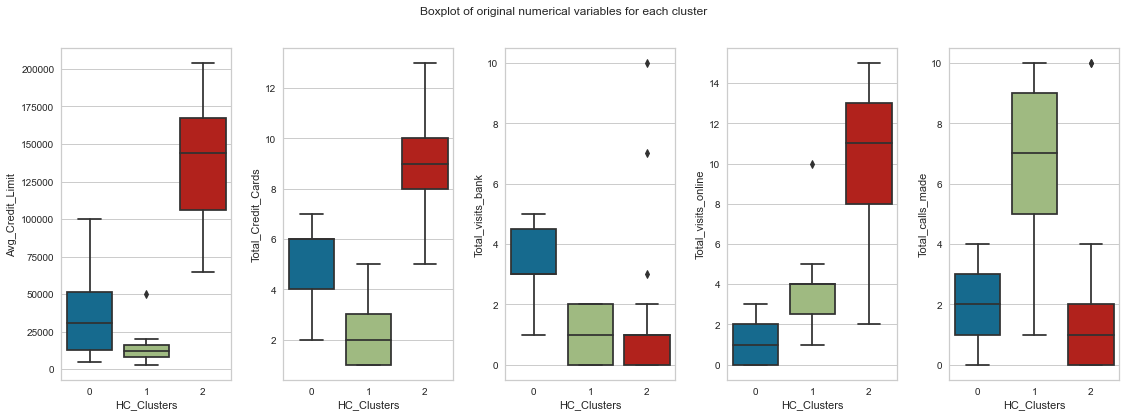

In [203]:
fig, axes = plt.subplots(1, 5, figsize=(16, 6))
fig.suptitle("Boxplot of original numerical variables for each cluster")
counter = 0
for ii in range(5):
    sns.boxplot(
        ax=axes[ii],
        y=df[num_col[counter]],
        x=df["HC_Clusters"],
    )
    counter = counter + 1

fig.tight_layout(pad=2.0)

## Dimensionality Reduction using PCA for visualization

- Let's use PCA to reduce the data to two dimensions and visualize it to see how well-separated the clusters are.

In [204]:
# Choosing the column of the scaled dataset to be displayed
subset_scaled_df = subset_scaled_df.iloc[:,:-1]

In [205]:
covMatrix = np.cov(subset_scaled_df, rowvar=False)
print(covMatrix)

[[ 1.00152905  0.621366   -0.07487304  0.55574635 -0.38510875]
 [ 0.621366    1.00152905  0.33449628  0.18423878 -0.616189  ]
 [-0.07487304  0.33449628  1.00152905 -0.53331005 -0.49489367]
 [ 0.55574635  0.18423878 -0.53331005  1.00152905  0.13512391]
 [-0.38510875 -0.616189   -0.49489367  0.13512391  1.00152905]]


In [206]:
pca = PCA(n_components=5)
pca.fit(subset_scaled_df)

PCA(n_components=5)

*The eigen Values*

In [207]:
print(pca.explained_variance_)

[2.26984538 1.85449678 0.36539064 0.27088339 0.24702907]


*The eigen Vectors*

In [208]:
print(pca.components_)

[[ 0.49739532  0.60083716  0.28701028  0.12686137 -0.54140918]
 [ 0.39625842  0.02857115 -0.58172398  0.66665551  0.24357873]
 [ 0.06333653  0.3098078   0.56564033  0.17152783  0.74204908]
 [-0.22150503  0.69673875 -0.50275465 -0.41237867  0.20657257]
 [-0.73654678  0.23822813  0.08069131  0.58309404 -0.2328872 ]]


*And the percentage of variation explained by each eigen Vector*

In [209]:
print(pca.explained_variance_ratio_)

[0.45327599 0.3703331  0.07296656 0.05409397 0.04933038]


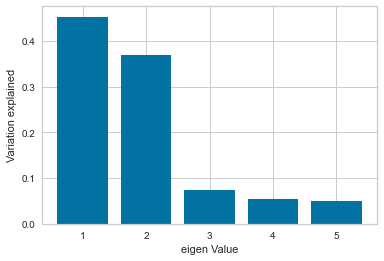

In [210]:
plt.bar(list(range(1, 6)), pca.explained_variance_ratio_, alpha=1, align="center")
plt.ylabel("Variation explained")
plt.xlabel("eigen Value")
plt.show()

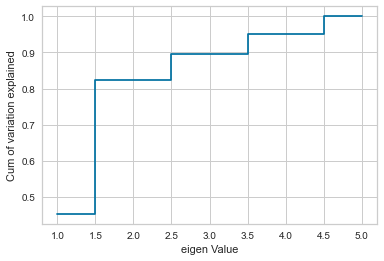

In [211]:
plt.step(list(range(1, 6)), np.cumsum(pca.explained_variance_ratio_), where="mid")
plt.ylabel("Cum of variation explained")
plt.xlabel("eigen Value")
plt.show()

### **Dimensionality Reduction**

- Now 3 dimensions seems very reasonable. With 3 variables we can explain almost 90% of the variation in the original data!
- The remaining variable kept the rest of 10% of information

In [212]:
pca3 = PCA(n_components=3)
pca3.fit(subset_scaled_df)
print(pca3.components_)
print(pca3.explained_variance_ratio_)
Xpca3 = pca3.transform(subset_scaled_df)

[[ 0.49739532  0.60083716  0.28701028  0.12686137 -0.54140918]
 [ 0.39625842  0.02857115 -0.58172398  0.66665551  0.24357873]
 [ 0.06333653  0.3098078   0.56564033  0.17152783  0.74204908]]
[0.45327599 0.3703331  0.07296656]


In [213]:
Xpca3

array([[ 1.57588817, -0.45370382, -0.43216947],
       [ 0.9529392 , -1.49085679,  0.30532451],
       [-1.07756597,  0.06509495, -0.42919156],
       ...,
       [-1.77670609,  0.64127145,  0.66573637],
       [-1.82282363,  1.27054008, -0.87942576],
       [ 2.62367232,  4.12015183,  0.41752599]])

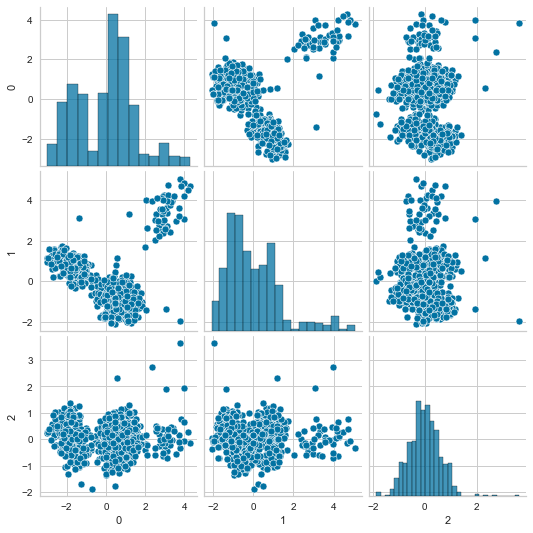

In [214]:
sns.pairplot(pd.DataFrame(Xpca3))

We can see that there is no linear correlation between the variables as the new vectors are orthogonal to one another

- Let's use PCA to reduce the data to two dimensions and visualize it to see how well-separated the clusters are.

In [215]:
# importing library
#from sklearn.decomposition import PCA

# setting the number of components to 3
pca = PCA(n_components=3)

# transforming data and storing results in a dataframe
X_reduced_pca = pca.fit_transform(subset_scaled_df)
reduced_df_pca = pd.DataFrame(
    data=X_reduced_pca, columns=["Component 1", "Component 2",'Component 3']
)

In [216]:
# checking the amount of variance explained
pca.explained_variance_ratio_.sum()

0.8965756497146328

<AxesSubplot:xlabel='Component 1', ylabel='Component 2'>

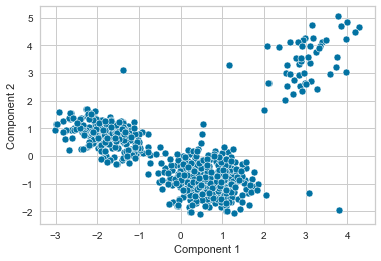

In [217]:
sns.scatterplot(data=reduced_df_pca, x="Component 1", y="Component 2")

- We can kind of see three broad clusters if we draw a horizontal line around y=1.
- There a few outlier points too.

Let's colour the scatterplot by cluster labels.

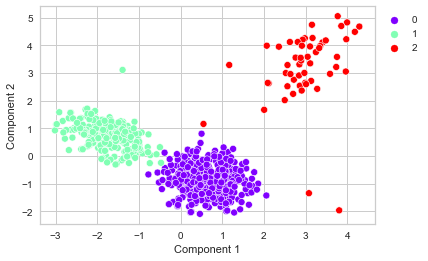

In [218]:
sns.scatterplot(
    data=reduced_df_pca,
    x="Component 1",
    y="Component 2",
    hue=df["HC_Clusters"],
    palette="rainbow",
)
plt.legend(bbox_to_anchor=(1, 1))

- Clusters 0,1 and 2 are the major clusters.

## Hierarchical clustering Insights (takeaways)

We will look into clusters 0, 1, and 2 only because there are no others.

- **Cluster 0**
   - There are 379 customers in this cluster.
   - The Average credit limit of customers of this cluster is from low to moderate.
   - The Total number of credit cards possessed by the customers is moderate.
   - The Total number of visits that customers made personally to the bank during the year is high.
   - The Total number of online logins made by the customers (yearly) is low.
   - The Total number of calls made by the customers to the bank's customers service department (yearly) is low to almost moderate.
   
   
- **Cluster 1**
   - There are 223 customers in this cluster.
   - The Average credit limit of customers of this cluster is very low.
   - The Total number of credit cards possessed by the customers is low.
   - The Total number of visits that customers made personally to the bank during the year is from low to almost moderate.
   - The Total number of online logins made by the customers (yearly) is moderate.
   - The Total number of calls made by the customers to the bank's customers service department (yearly) is high.
    
   
- **Cluster 2**
   - There are 53 customers in this cluster.
   - The customers of the cluster 2 have a the highest Average credit limit.
   - The Total number of credit cards possessed by the customers is high.
   - The Total number of visits that customers made personally to the bank during the year is low.
   - The Total number of online logins made by the customers (yearly) is high.
   - The Total number of calls made by the customers to the bank's customers service department (yearly) is low .

## K-means vs Hierarchical Clustering

**K-means and Hierarchical clustering techniques clustering comparison**

- *The clusters are almost the same, no matter the clustering technique used*
- *From the results above, it clearly appears that, due to the clustering techniques applied (K-Means or Hierarchical), there are some (few) customers who got transfered from a cluster to another*
- *Hierarchical clustering (9.14 seconds) takes longer to run than K-Means (1.5 seconds). Here, we only have 655 observations on half a dozen features. If the observations were counted in terms of tens of thousands or millions, on a high number of features, the execution times would have been much longer and the difference in execution between the two techniques, even more exorbitant.*

In [219]:
# identifying customers who got transfered from a cluster to another
df[(df['K_means_segments'] == 2) | (df['HC_Clusters'] == 2)].value_counts().sample(n=5, random_state=1)

Customer Key  Avg_Credit_Limit  Total_Credit_Cards  Total_visits_bank  Total_visits_online  Total_calls_made  K_means_segments  HC_Clusters
16180         163000            7                   1                  10                   1                 2                 2              1
58392         186000            7                   0                  8                    1                 2                 2              1
51108         99000             10                  1                  10                   0                 2                 2              1
18519         127000            10                  1                  15                   1                 2                 2              1
17538         153000            8                   1                  7                    1                 2                 2              1
dtype: int64

In [220]:
# identifying customers who got transfered from a cluster to another
df[(df['K_means_segments'] == 1) | (df['HC_Clusters'] == 0)].value_counts().sample(n=5, random_state=1)

Customer Key  Avg_Credit_Limit  Total_Credit_Cards  Total_visits_bank  Total_visits_online  Total_calls_made  K_means_segments  HC_Clusters
83459         5000              4                   5                  0                    1                 1                 0              1
39644         56000             6                   4                  0                    3                 1                 0              1
88411         56000             7                   3                  0                    1                 1                 0              1
24748         73000             5                   3                  0                    4                 1                 0              1
50878         10000             4                   5                  0                    3                 1                 0              1
dtype: int64

- The 2 clustering techniques establish an optimal number of clusters to 3.
- The results of customer segmentation obtained by each clustering technique are almost the same. One dominant cluster, a second dominant one and a smaller cluster.
- With the K-means technique, we have a cluster with 222 customers (cluster 0), 1 other cluster with 383 customers (cluster 1) and the last one with 50 customers (cluster 2).
- With Hierarchical clustering technique, we have a cluster with 379 customers (cluster 0), 1 other with 223 customers (cluster 1) and the last one with 53 customers (cluster 2).
- A close comparison of the two clustering techniques' results reveals that the dominant cluster (cluster 1) obtained with the K-means technique loses 4 clients, to the benefit of two clusters     formed with hierarchical clustering. 
- Indeed, compared to K-means clustering, cluster 2 of the hierarchical technique gained 3 new customers (53 customers) and its cluster 1 gained 1 new customer (223 customer).
- Customers with *Custoemer Key* 37252, 50706 and 96929 have moved from the K-means technique's cluster 1 to the Hierarchical techniques's cluster 2.
- Customer with *Customer Key* 49331 has, for his part, moved from the K-means technique's cluster 1 to the Hierarchical techniques's cluster 1.


## Recommendations

- Before increasing its market penetration rate, the bank must first ensure the loyalty of its current customers. The bank must strive and ensure that it meets the expectations of its current customers. It must set up a questionnaire to collect the current customers feedbacks and level of satisfaction.

- The results of customer clustering will enable the bank to improve its customer experience. Indeed, based on these results, Its marketing department should implement a relational marketing strategy. The relational marketing strategy which is based at segmenting clients, will help the bank to better understand them, to better know who it is addressing, in order to establish a relevant and personalized conversation (interaction) for each interlocutor, as closely as possible to the expectations and needs of its prospects and clients.

- By working on the lasting bond of the customer relationship, the bank will promote the acquisition of new products and services from its existing customers as well as curious consumers. It will thus boost its customer retention rates. For example, thanks to the benefits of customer knowledge, the marketing departement of the bank could generate tailor-made campaigns with customer knowledge

- The bank must accelerate its digital transformation by making sure to move from selling services to offering innovative financial experiences. Online banks are becoming more and more attractive and faced with ever-widening choices, customers are volatile. Only Customers with a high credit limit like to hold multiple credit cards and prefer online channels to contact the bank for their queries. These are people who have a relationship of trust with digital. 
tools. 